In [1]:
data_model_stealing = './ModelStealingPub.pt'

In [2]:
import torch
from typing import Tuple
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:

class TaskDataset(Dataset):
    def __init__(self, data, transform=None):
        self.ids = data.ids
        self.imgs = data.imgs
        self.labels = data.labels
        self.transform = transform if transform is not None else transforms.Compose([
            transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
            transforms.ToTensor()
        ])

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        img = self.transform(img)
        label = self.labels[index]
        return id_, img, label

    def __len__(self):
        return len(self.ids)

class ModelStealingData(TaskDataset):
    def __init__(self, data, transform=None):
        super().__init__(data, transform)

In [4]:
# dataset load
data = torch.load(data_model_stealing)
dataset = ModelStealingData(data)
dataloader = DataLoader(dataset, batch_size=len(dataset))

# extracting images and labels from the dataset
data_iter = iter(dataloader)
ids, imgs, labels = next(data_iter)

#type of labels
print(type(labels))
print(labels)

# labels converted to a list or numpy array
if isinstance(labels, tuple):
    labels_np = np.array(labels)
else:
    labels_np = labels.numpy()

# images to numpy array and flatten
imgs_np = imgs.numpy().reshape(len(imgs), -1)

# mapping labels to integers
if labels_np.dtype.kind in {'U', 'S'}:
    unique_labels = list(set(labels_np))
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    labels_np = np.array([label_map[label] for label in labels_np])
else:
    unique_labels = np.unique(labels_np)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}


<class 'tuple'>
('40019202', '10964686', '62225416', '26466207', '24683694', '26466207', '90386222', '15103694', '62225416', '14119474', '62225416', '75986657', '62014378', '90386222', '15103694', '62225416', '62225416', '62014378', '15103694', '14119474', '26466207', '62225416', '15103694', '15256249', '14119474', '62225416', '64963739', '83450130', '75986657', '62225416', '92257871', '40019202', '50011542', '26466207', '68395620', '24683694', '19888903', '15103694', '15103694', '75986657', '31527279', '15103694', '15256249', '62225416', '67716412', '23255817', '50011542', '74777746', '75652382', '15103694', '26466207', '26466207', '62014378', '15256249', '62014378', '62014378', '68395620', '75652382', '62225416', '75986657', '90386222', '24683694', '24683694', '90386222', '62014378', '15103694', '62225416', '62014378', '67716412', '31527279', '40019202', '90386222', '55364435', '62014378', '62014378', '83450130', '83450130', '68395620', '24683694', '62014378', '74777746', '74777746',

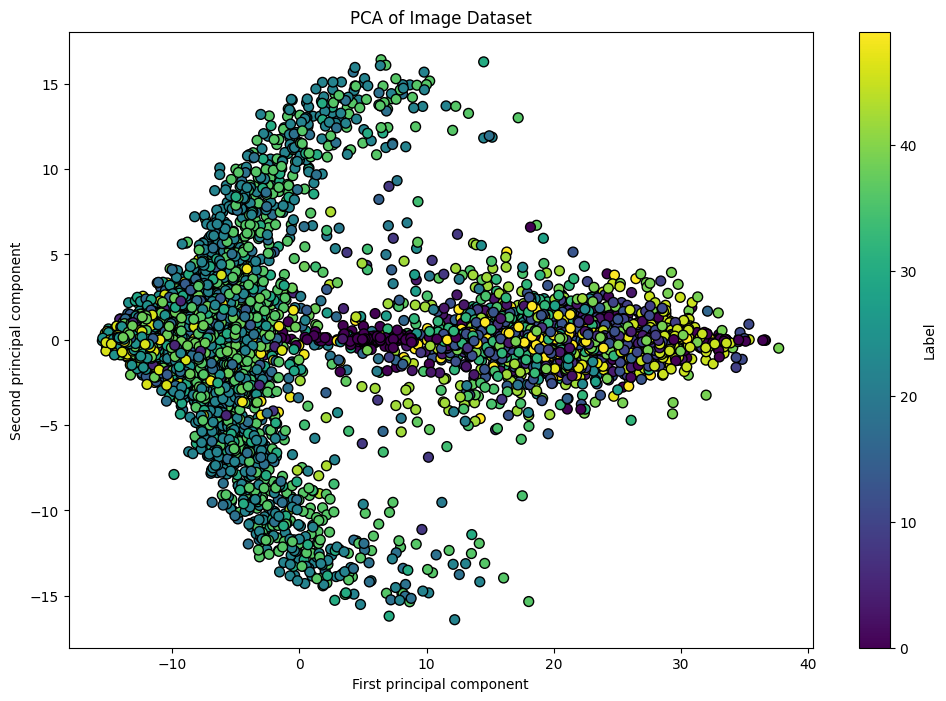

In [5]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(imgs_np)

# projection by PCA
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_np, cmap='viridis', edgecolor='k', s=50)
plt.title('PCA of Image Dataset')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.colorbar(scatter, label='Label')
plt.show()

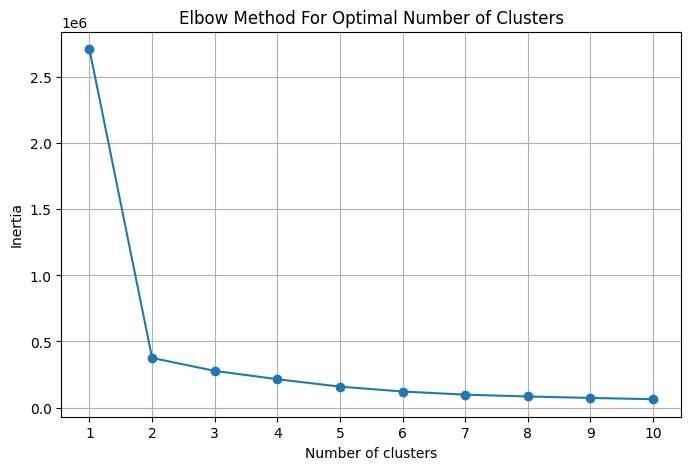

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Compute K-Means clustering for different numbers of clusters
inertia = []
range_n_clusters = range(1, 11)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()


K-Means Silhouette Score: 0.78534334897995


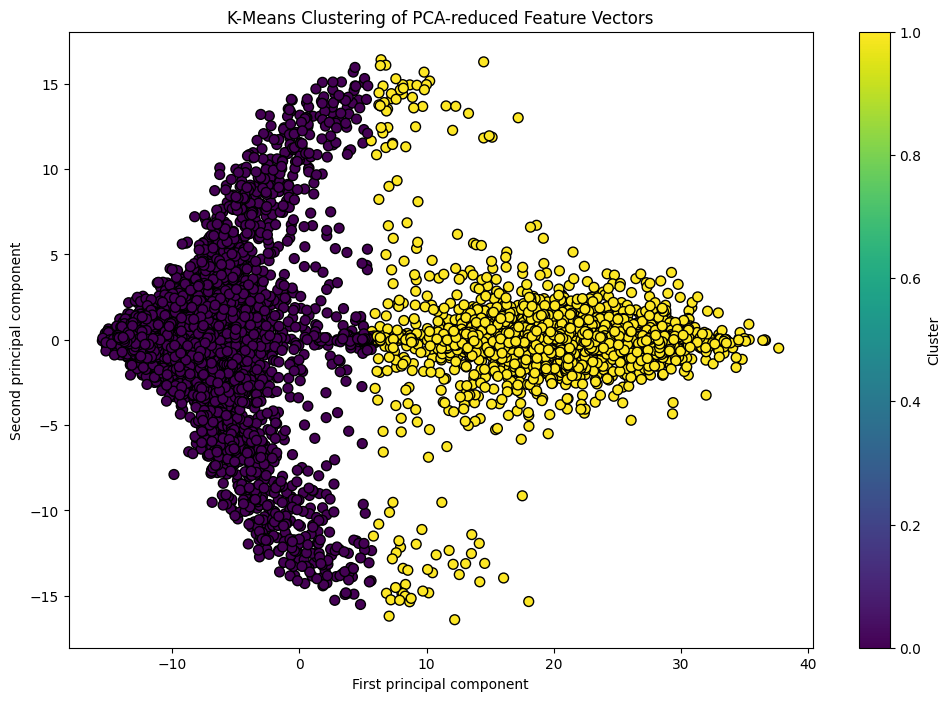

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

#Elbow Method shows that the optimal cluster number for this data is 2 and high K-Means Silhouette score confirms it

# K-Means Clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_pca)
kmeans_labels = kmeans.labels_



#silhouette scores
kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)


print(f"K-Means Silhouette Score: {kmeans_silhouette}")

# Plotting the K-Means clusters
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', edgecolor='k', s=50)
plt.title('K-Means Clustering of PCA-reduced Feature Vectors')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.colorbar(label='Cluster')
plt.show()



In [9]:
!pip3 install datasketch

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 89 kB 3.4 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [10]:
from datasketch import MinHash, MinHashLSH
import numpy as np
from sklearn.cluster import KMeans

num_hashes = 256  # Number of hash functions
lsh_threshold = 0.5  # Threshold for Local sensitive hashing (used in paper)
num_buckets = 2**12  # 2^12 hash buckets (optimal number of buckets used in paper)

lsh_individual = MinHashLSH(threshold=lsh_threshold, num_perm=num_hashes)
lsh_centroids = MinHashLSH(threshold=lsh_threshold, num_perm=num_hashes)


optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)
centroids = kmeans.cluster_centers_

#hash centroids to LSH
centroid_hashes = []
for i, centroid in enumerate(centroids):
    minhash = MinHash(num_perm=num_hashes)
    for dimension in centroid:
        minhash.update(dimension.tobytes())
    centroid_hashes.append(minhash)
    lsh_centroids.insert(f"centroid_{i}", minhash)

print("LSH Hashing of Cluster Centroids completed.")

#hash individual feature vectors to LSH
feature_vector_hashes = []
for i, vector in enumerate(X_pca):
    minhash = MinHash(num_perm=num_hashes)
    for dimension in vector:
        minhash.update(dimension.tobytes())
    feature_vector_hashes.append(minhash)
    lsh_individual.insert(f"vector_{i}", minhash)

print("LSH Hashing of Individual Feature Vectors completed.")


LSH Hashing of Cluster Centroids completed.
LSH Hashing of Individual Feature Vectors completed.


In [11]:
#tracking unique hash buckets for individual feature vectors by cluster
occupied_buckets_by_cluster = {i: set() for i in range(optimal_clusters)}

for i, vector in enumerate(X_pca):
    minhash = MinHash(num_perm=num_hashes)
    for dimension in vector:
        minhash.update(dimension.tobytes())
    cluster_id = kmeans_labels[i]
    occupied_buckets_by_cluster[cluster_id].update(lsh_individual.query(minhash))

print("LSH Hashing of Individual Feature Vectors completed by cluster.")

#tracking unique hash buckets for centroids
occupied_buckets_centroids = set()
for minhash in centroid_hashes:
    bucket = lsh_centroids.query(minhash)
    occupied_buckets_centroids.update(bucket)


total_possible_buckets = lsh_individual.b

#fraction of occupied buckets for centroids
coverage_fraction_centroids = len(occupied_buckets_centroids) / total_possible_buckets

#fraction of occupied buckets for individual vectors by cluster
coverage_fractions_individual_by_cluster = {}
for cluster_id, occupied_buckets in occupied_buckets_by_cluster.items():
    coverage_fraction_individual = len(occupied_buckets) / total_possible_buckets
    coverage_fractions_individual_by_cluster[cluster_id] = coverage_fraction_individual

#comparison
print(f"Coverage fraction of the embedding space by cluster centroids: {coverage_fraction_centroids:.4f}")
print("Coverage fraction of the embedding space by individual feature vectors in each cluster:")
for cluster_id, coverage_fraction in coverage_fractions_individual_by_cluster.items():
    print(f"Cluster {cluster_id}: {coverage_fraction:.4f}")


LSH Hashing of Individual Feature Vectors completed by cluster.
Coverage fraction of the embedding space by cluster centroids: 0.0476
Coverage fraction of the embedding space by individual feature vectors in each cluster:
Cluster 0: 94.5476
Cluster 1: 214.9762


In [12]:
#paths in Google Drive
drive_path_cluster_0 = './dataset_cluster_0.pt'
drive_path_cluster_1 = './dataset_cluster_1.pt'


In [14]:
#indices for clusters 0 and 1
indices_cluster_0 = np.where(kmeans_labels == 0)[0]
indices_cluster_1 = np.where(kmeans_labels == 1)[0]

# retrieving original images and labels
images_cluster_0 = [imgs[i] for i in indices_cluster_0]
labels_cluster_0 = [labels_np[i] for i in indices_cluster_0]

images_cluster_1 = [imgs[i] for i in indices_cluster_1]
labels_cluster_1 = [labels_np[i] for i in indices_cluster_1]

#custom dataset class for saving
class ClusterDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


#datasets for cluster 0 and cluster 1 (subsets of the original dataset)
dataset_cluster_0 = ClusterDataset(images_cluster_0, labels_cluster_0)
dataset_cluster_1 = ClusterDataset(images_cluster_1, labels_cluster_1)

# Saving datasets as .pt files in Google Drive
torch.save(dataset_cluster_0, drive_path_cluster_0)
torch.save(dataset_cluster_1, drive_path_cluster_1)

print("Datasets for cluster 0 and cluster 1 saved to path as .pt files.")

Datasets for cluster 0 and cluster 1 saved to path as .pt files.


In [27]:
import sys
import base64
import io
import json
import requests
import time
import torch
from torchvision.transforms import ToPILImage

In [17]:

TOKEN = "40034445"
response = requests.get("http://34.71.138.79:9090" + "/stealing_launch", headers={"token": TOKEN})
answer = response.json()
print(answer)
if 'detail' in answer:
    sys.exit(1)

SEED = str(answer['seed'])
PORT = str(answer['port'])


In [18]:
SEED = '20499754'
PORT = '9052'

In [19]:
### QUERYING THE API ###
def model_stealing(images, port):
    endpoint = "/query"
    url = f"http://34.71.138.79:{port}" + endpoint
    image_data = []
    for img in images:
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='PNG')
        img_byte_arr.seek(0)
        img_base64 = base64.b64encode(img_byte_arr.getvalue()).decode('utf-8')
        image_data.append(img_base64)
    
    payload = json.dumps(image_data)
    response = requests.get(url, files={"file": payload}, headers={"token": "40034445"})
    if response.status_code == 200:
        representation = response.json()["representations"]
        return representation
    else:
        raise Exception(
            f"Model stealing failed. Code: {response.status_code}, content: {response.json()}"
        )


In [20]:
dataset_0 = torch.load('./dataset_cluster_0.pt')

In [29]:
print(type(dataset_0.images[0]))

<class 'torch.Tensor'>


In [35]:
def to_pil_image(tensor):
    return ToPILImage()(tensor).convert("RGB")

In [48]:
images_to_send = [to_pil_image(img) for img in dataset_0.images]


In [50]:
print(len(images_to_send))

3971


In [49]:
print(type(images_to_send[0]))

<class 'PIL.Image.Image'>


In [51]:
representations = []
batches = len(images_to_send) // 1000
for i in range(batches):
    print(f"Processing batch {i + 1}/{batches}")
    images = images_to_send[i * 1000: (i + 1) * 1000]
    representations.append(model_stealing(images, PORT))
    print(f'Finished batch {i + 1}/{batches}. Sleeping')
    time.sleep(60)


Processing batch 1/3
Finished batch 1/3. Sleeping
Processing batch 2/3
Finished batch 2/3. Sleeping
Processing batch 3/3
Finished batch 3/3. Sleeping


In [56]:
print(len(representations[0]))


1000


In [57]:
dataset_1 = torch.load('./dataset_cluster_1.pt')
images_to_send_dataset_1 = [to_pil_image(img) for img in dataset_1.images]

In [58]:
print(len(images_to_send_dataset_1))
print(type(images_to_send_dataset_1[0]))

9029
<class 'PIL.Image.Image'>


In [60]:
batches = len(images_to_send_dataset_1) // 1000
for i in range(batches):
    print(f"Processing batch {i + 1}/{batches}")
    images = images_to_send_dataset_1[i * 1000: (i + 1) * 1000]
    representations.append(model_stealing(images, PORT))
    print(f'Finished batch {i + 1}/{batches}. Sleeping')
    if i != batches - 1:
        time.sleep(60)

Processing batch 1/9
Finished batch 1/9. Sleeping
Processing batch 2/9
Finished batch 2/9. Sleeping
Processing batch 3/9
Finished batch 3/9. Sleeping
Processing batch 4/9
Finished batch 4/9. Sleeping
Processing batch 5/9
Finished batch 5/9. Sleeping
Processing batch 6/9
Finished batch 6/9. Sleeping
Processing batch 7/9
Finished batch 7/9. Sleeping
Processing batch 8/9
Finished batch 8/9. Sleeping
Processing batch 9/9
Finished batch 9/9. Sleeping
